# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import cv2
import numpy as np
from collections import Counter
from sklearn.preprocessing import LabelBinarizer
import matplotlib.image as mpimg

In [8]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def normalize(X):
    a,b,xmin,xmax = 0.1,0.9,0,255
    return a+(X-xmin)*(b-a)/(xmax-xmin)

def grayscale_4d(X):
    X_gray = np.empty(X[:,:,:,0].shape)
    for i in range(len(X_gray)):
        X_gray[i] = normalize_grayscale(grayscale(X[i]))
    return(X_gray)

def flat_3d(X):
    n, a,b = X.shape[0],X.shape[1],X.shape[2]
    X_flat = np.empty((n,a*b))
    for i in range(len(X_flat)):
        X_flat[i] = X[i].reshape(a*b)
    return(X_flat)

def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

def flatten_x(x):
    # Get the shape of the input layer.
    x_shape = x.shape

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
#     num_features = x_shape[1:4].num_elements()
    num_features = np.prod(x_shape[1:4])
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    x_flat = np.reshape(x, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return x_flat, num_features

In [9]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = 'lab 2 data/train.p'
testing_file = 'lab 2 data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

# images and class number
X_train, y_train_cls = train['features'], train['labels']
X_test, y_test_cls = test['features'], test['labels']

# shuffle the training data
X_train,y_train_cls = shuffle_in_unison(X_train, y_train_cls)

X_train = normalize(X_train)

X_train_flat, X_train_flat_features = flatten_x(X_train)

encoder = LabelBinarizer()
encoder.fit(y_train_cls)
y_train = encoder.transform(y_train_cls).astype(np.float32)
y_test = encoder.transform(y_test_cls).astype(np.float32)

# X_train = grayscale_4d(X_train)
# X_test = grayscale_4d(X_test)

# X_train = flat_3d(X_train)
# X_test = flat_3d(X_test)

In [10]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(y_train_cls)

# TODO: number of testing examples
n_test = len(y_test_cls)

# TODO: what's the shape of an image?
num_channels = 3
img_size = 32
img_shape = (img_size, img_size, num_channels)

# TODO: how many classes are in the dataset
num_classes = len(Counter(y_train_cls)) #43


print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", img_shape)
print("Number of classes =", num_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [ ]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

In [11]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

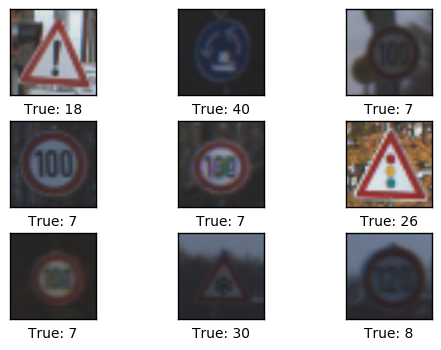

In [77]:
# Get the first images from the test-set.
images = X_train_flat[0:9]

# Get the true classes for those images.
cls_true = y_train_cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Weight and bias helpers

In [13]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [14]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

### Layer helpers

In [15]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=False): # Use Rectified Linear Unit (ReLU)?

    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    layer = tf.matmul(input, weights) + biases

    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [16]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [17]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

### Placeholders

In [18]:
x = tf.placeholder(tf.float32, [None, img_size, img_size, num_channels])

y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.placeholder(tf.int64, [None])

# probability for dropout
keep_prob = tf.placeholder("float")

In [94]:
# First convolutional layer
conv1_filter_size = 5
conv1_num_filters = 16

layer_conv1, weights_conv1 = new_conv_layer(x,              # The previous layer.
                   num_channels, # Num. channels in prev. layer.
                   conv1_filter_size,        # Width and height of each filter.
                   conv1_num_filters,        # Number of filters.
                   use_pooling=True)  # Use 2x2 max-pooling.

layer_dropout1 = tf.nn.dropout(layer_conv1, keep_prob)

# Second convolutional layer

conv2_filter_size = 5
conv2_num_filters = 24

layer_conv2, weights_conv2 = new_conv_layer(layer_dropout1,              # The previous layer.
                   conv1_num_filters, # Num. channels in prev. layer.
                   conv2_filter_size,        # Width and height of each filter.
                   conv2_num_filters,        # Number of filters.
                   use_pooling=True)  # Use 2x2 max-pooling.

layer_dropout2 = tf.nn.dropout(layer_conv2, keep_prob)

# Third convolutional layer

conv3_filter_size = 5
conv3_num_filters = 32

layer_conv3, weights_conv3 = new_conv_layer(layer_dropout2,              # The previous layer.
                   conv2_num_filters, # Num. channels in prev. layer.
                   conv3_filter_size,        # Width and height of each filter.
                   conv3_num_filters,        # Number of filters.
                   use_pooling=True)  # Use 2x2 max-pooling.

layer_dropout3 = tf.nn.dropout(layer_conv3, keep_prob)

# Flatten second conv layer for FC layer

layer_flat, num_features = flatten_layer(layer_dropout3)

# First FC layer

fc1_out_features = 32

layer_fc1 = new_fc_layer(layer_flat,          # The previous layer.
                 num_features,     # Num. inputs from prev. layer.
                 fc1_out_features,    # Num. outputs.
                 use_relu=True) # Use Rectified Linear Unit (ReLU)?

# Last FC layer

layer_last = new_fc_layer(layer_fc1,          # The previous layer.
                 fc1_out_features,     # Num. inputs from prev. layer.
                 num_classes,    # Num. outputs.
                 use_relu=False) # Use Rectified Linear Unit (ReLU)?

# get softmax and predicted class

y_pred = tf.nn.softmax(layer_last)
y_pred_cls = tf.argmax(y_pred, dimension=1)


# cost function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_last, labels=y_true)
cost = tf.reduce_mean(cross_entropy)

### Optimizer

In [22]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)

### Accuracy

In [23]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Create session and initialize variables

In [24]:
session = tf.Session()
session.run(tf.initialize_all_variables())

### Optimize function for training

In [27]:
batch_size = 512

In [91]:
def optimize(num_iterations):
    for i in range(num_iterations):
        
        batch_start = i*batch_size % len(X_train)
        batch_end = min(batch_start+batch_size,len(X_train))
        x_batch = X_train[batch_start:batch_end]
        y_true_batch = y_train[batch_start:batch_end]
        y_true_batch_cls = y_train_cls[batch_start:batch_end]
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        # Note that the placeholder for y_true_cls is not set
        # because it is not used during training.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch,
                           keep_prob: 0.5}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        _, batch_cost = session.run([optimizer, cost], feed_dict=feed_dict_train)
        
        # Print status every 100 iterations.
        if i % 20 == 0:
            feed_dict_train_accuracy = {x: x_batch, y_true: y_true_batch, y_true_cls: y_true_batch_cls, keep_prob: 1.0}
            acc = session.run(accuracy, feed_dict=feed_dict_train_accuracy)
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}, Batch Cost: {2}"
            print(msg.format(i + 1, acc, batch_cost))

### Testing

In [29]:
feed_dict_test = {x: X_test,
                  y_true: y_test,
                  y_true_cls: y_test_cls,
                  keep_prob: 1.0}

In [30]:
def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))

### Visualizations

In [31]:
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = y_test_cls
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

In [32]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = X_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = y_test_cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

#### Plot weights viz, needs to be updated for conv layers

In [33]:
# def plot_weights():
#     # Get the values for the weights from the TensorFlow variable.
#     w = session.run(weights)
    
#     # Get the lowest and highest values for the weights.
#     # This is used to correct the colour intensity across
#     # the images so they can be compared with each other.
#     w_min = np.min(w)
#     w_max = np.max(w)

#     # where the last 2 sub-plots are unused.
#     fig, axes = plt.subplots(5, 10)
#     fig.subplots_adjust(hspace=1, wspace=1)

#     for i, ax in enumerate(axes.flat):
#         # Only use the weights for the first 10 sub-plots.
#         if i<num_classes:
#             # Get the weights for the i'th digit and reshape it.
#             # Note that w.shape == (img_size_flat, 10)
#             image = w[:, i].reshape(img_shape)

#             # Set the label for the sub-plot.
#             ax.set_xlabel("W: {0}".format(i))

#             # Plot the image.
#             ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

#         # Remove ticks from each sub-plot.
#         ax.set_xticks([])
#         ax.set_yticks([])

## Training

In [34]:
print_accuracy()

Accuracy on test-set: 0.5%


### Train and print accuracy every 100 iterations

In [36]:
for i in range(1):
    optimize(num_iterations=100)
    print_accuracy()

Optimization Iteration:      1, Training Accuracy:   8.4%, Batch Cost: 3.7689385414123535
Optimization Iteration:     21, Training Accuracy:   6.2%, Batch Cost: 3.530919075012207
Optimization Iteration:     41, Training Accuracy:   6.4%, Batch Cost: 3.5234761238098145
Optimization Iteration:     61, Training Accuracy:   7.6%, Batch Cost: 3.5381698608398438
Optimization Iteration:     81, Training Accuracy:   6.6%, Batch Cost: 3.5310416221618652
Accuracy on test-set: 5.8%


In [37]:
for i in range(10):
    optimize(num_iterations=100)
    print_accuracy()

Optimization Iteration:      1, Training Accuracy:   8.4%, Batch Cost: 3.494828462600708
Optimization Iteration:     21, Training Accuracy:  10.2%, Batch Cost: 3.4922537803649902
Optimization Iteration:     41, Training Accuracy:   7.0%, Batch Cost: 3.4995930194854736
Optimization Iteration:     61, Training Accuracy:   8.2%, Batch Cost: 3.5100955963134766
Optimization Iteration:     81, Training Accuracy:   8.2%, Batch Cost: 3.5075316429138184
Accuracy on test-set: 8.0%
Optimization Iteration:      1, Training Accuracy:  11.1%, Batch Cost: 3.4606683254241943
Optimization Iteration:     21, Training Accuracy:  11.7%, Batch Cost: 3.454218626022339
Optimization Iteration:     41, Training Accuracy:   6.4%, Batch Cost: 3.471914291381836
Optimization Iteration:     61, Training Accuracy:  10.7%, Batch Cost: 3.4258780479431152
Optimization Iteration:     81, Training Accuracy:  17.2%, Batch Cost: 3.3975608348846436
Accuracy on test-set: 13.4%
Optimization Iteration:      1, Training Accurac

In [38]:
for i in range(100):
    optimize(num_iterations=100)
    print_accuracy()

Optimization Iteration:      1, Training Accuracy:  47.5%, Batch Cost: 1.8227190971374512
Optimization Iteration:     21, Training Accuracy:  46.3%, Batch Cost: 1.8284865617752075
Optimization Iteration:     41, Training Accuracy:  50.0%, Batch Cost: 1.823812484741211
Optimization Iteration:     61, Training Accuracy:  48.6%, Batch Cost: 1.7869150638580322
Optimization Iteration:     81, Training Accuracy:  52.7%, Batch Cost: 1.7115203142166138
Accuracy on test-set: 41.7%
Optimization Iteration:      1, Training Accuracy:  47.9%, Batch Cost: 1.8083655834197998
Optimization Iteration:     21, Training Accuracy:  46.9%, Batch Cost: 1.769012212753296
Optimization Iteration:     41, Training Accuracy:  50.6%, Batch Cost: 1.7393929958343506
Optimization Iteration:     61, Training Accuracy:  50.8%, Batch Cost: 1.7670738697052002
Optimization Iteration:     81, Training Accuracy:  54.5%, Batch Cost: 1.6613188982009888
Accuracy on test-set: 43.1%
Optimization Iteration:      1, Training Accur

In [39]:
for i in range(100):
    optimize(num_iterations=100)
    print_accuracy()

Optimization Iteration:      1, Training Accuracy:  98.4%, Batch Cost: 0.42979252338409424
Optimization Iteration:     21, Training Accuracy:  98.6%, Batch Cost: 0.3993982672691345
Optimization Iteration:     41, Training Accuracy:  99.2%, Batch Cost: 0.34027162194252014
Optimization Iteration:     61, Training Accuracy:  97.7%, Batch Cost: 0.41373467445373535
Optimization Iteration:     81, Training Accuracy:  97.7%, Batch Cost: 0.35327857732772827
Accuracy on test-set: 88.6%
Optimization Iteration:      1, Training Accuracy:  99.0%, Batch Cost: 0.37385261058807373
Optimization Iteration:     21, Training Accuracy:  97.3%, Batch Cost: 0.41840487718582153
Optimization Iteration:     41, Training Accuracy:  99.2%, Batch Cost: 0.3307899236679077
Optimization Iteration:     61, Training Accuracy:  98.4%, Batch Cost: 0.3430843651294708
Optimization Iteration:     81, Training Accuracy:  97.3%, Batch Cost: 0.36475858092308044
Accuracy on test-set: 91.7%
Optimization Iteration:      1, Train

In [90]:
for i in range(1):
    optimize(num_iterations=100)
    print_accuracy()

[[  1.76753653e-28   6.44498287e-23   3.31347711e-26 ...,   1.80168828e-30
    4.14830546e-32   8.48796185e-34]
 [  5.59041835e-09   7.53951554e-07   3.11718418e-06 ...,   9.92213070e-01
    7.02362797e-07   1.36150868e-06]
 [  5.37911947e-05   2.82356348e-02   4.90748743e-03 ...,   3.29240065e-05
    2.05705275e-09   2.74645640e-06]
 ..., 
 [  2.60265301e-06   1.89046532e-05   6.27476911e-05 ...,   8.67844747e-08
    1.49785762e-07   1.58610514e-10]
 [  9.74540626e-08   1.92446878e-05   9.02614614e-04 ...,   3.36781780e-09
    8.53555941e-12   3.85292367e-07]
 [  2.12951261e-03   9.49255452e-02   2.47267023e-01 ...,   2.55229287e-02
    2.32416694e-03   2.23011221e-03]]
Optimization Iteration:      1, Training Accuracy:  99.6%, Batch Cost: 0.26063042879104614
[[  1.18081739e-10   5.32698441e-10   4.77063811e-09 ...,   6.56451456e-13
    5.23195333e-12   1.17893488e-12]
 [  7.62027921e-05   9.86980617e-01   1.19002983e-02 ...,   1.10696180e-06
    2.58105842e-10   1.89913618e-09]
 [  1

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

I normalized the data and one-hot encoded the labels. My reviewer pointed out that (presumably because our weights are initialized around zero) the model will converge faster if the data is centered around zero as well. It does seem like making the numbers smaller would save you learning time if you have a fixed small learning rate, and depending on activation functions, would help keep you out of the saturation range. My undestanding of the purpose of one-hot encoding is that it provides an easy way to measure how close a prediction is to the correct class by calculating cross entropy from the predicted class (some probability for each class) and the correct class (1 for the correct class, 0 for the rest).

Some time after training, I noticed my network would predict a particular class too often, and that I got better results shuffling the data. In the future I would like to see the results of shuffling every epoch, or randomly sampling batches and validation data. I would also consider grayscaling the data since hte LeCun paper took that approach.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

I just had training and test data sets and did not generate additional data. I would like to see if I can improve results by splitting my data into folds and using the cross-validation technique to reduce overfitting to the training data.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

My final network consists of convolutional layers and dropouts, followed by fully connected layers. I built this up incrementally as I got more comfortable with understanding convnets and tensorflow, starting with a single FC layer, adding another, then adding convolutional layers, and finally adding dropout into the mix. I would definitely spend a lot more time in the future trying different architectures and thinking about how to build intuition about what I'm doing.

Specifically, depending on what you count as a layer I have 13 layers, 3 conv-pool-dropout combinations, followed by a hidden FC layer with ReLU, followed by the output FC layer and softmax:

- Conv (16 5x5 filters)
- 2x2 max-pooling
- 50% dropout
- Conv (24 5x5 filters)
- 2x2 max-pooling
- 50% dropout
- Conv (32 5x5 filters)
- 2x2 max-pooling
- 50% dropout
- Hidden FC (32 outputs)
- ReLU
- Output FC (43 outputs, one per class)
- Softmax

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I trained the model for quite a while, 21100 iterations with a batch size of 512! I used the gradient descent optimizer (as that is one I understood from the lecture material) with a learning rate of 0.1. I trained it for enough epochs until I saw the test set accuracy was no longer improving.

I spent some time changing these hyperparameters, but I would really like to improve this in the future as I learn more about neural nets. I'm developing more as I review external sources, especially Andrej Karpathy's lectures. Once I get through with those, I plan to return and do the following:
1. Get running on a GPU so I can try out different architectures and hyperparameters much faster.
2. Do a lot of testing and track the results. This might include randomly sampling across hyperparameters and seeing what combinations work well.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

Being frank, I felt like the course material didn't cover the material sufficiently for me to make progress. So I spent a vast majority of my time between projects 1 and 2 looking for quality materials outside of the course in order to develop a stronger undrestanding of tensorflow, backpropagation, convnets, and training approaches. My first approach was to take a working network in tensforflow (found here: https://github.com/Hvass-Labs/TensorFlow-Tutorials) and play with it to get a clerer undrstanding of tensorflow. After grasping the basics, I went back to search for more materials on backprop and found the Karpathy videos. Once I felt more comfortable in my understanding of the system, I put togther my neural network, building up in complexity.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [6]:
img1 = mpimg.imread('img1.jpg')
img2 = mpimg.imread('img2.jpg')
img3 = mpimg.imread('img3.jpg')
img4 = mpimg.imread('img4.jpg')
img5 = mpimg.imread('img5.jpg')
X_new = np.concatenate((img1,img2,img3,img4,img5), axis=0).reshape(-1,32,32,3)
y_new_cls = np.array([14,26,14,4,38])
encoder = LabelBinarizer()
encoder.fit(y_train_cls)
y_new = encoder.transform(y_new_cls).astype(np.float32)

feed_dict_new = {x: X_new,
                  y_true: y_new,
                  y_true_cls: y_new_cls,
                  keep_prob: 1.0}

correct, cls_pred, pred = session.run([correct_prediction, y_pred_cls, y_pred], feed_dict=feed_dict_new)

# print(y_new_cls,cls_pred,y_pred)
print(pred)

NameError: name 'x' is not defined

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In the images I selected, the one that was just a drawing of a sign (rather than a photograph) was incorrectly classified by the model. However, it was pretty close - instead of recoginizing a red triangle with a traffic light, it predicted a red traffic sign with an exclamation point.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [110]:
def plot_plots(pred):
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(5, 1)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.plot(np.arange(num_classes),pred[i],'ro')
        ax.axis([0, 43, 0, 1])
        ax.set_xlabel(i)
        

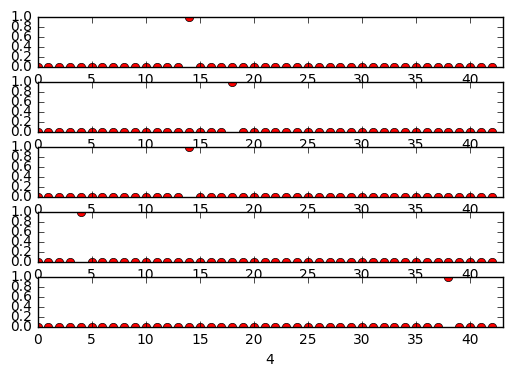

In [111]:
plot_plots(pred)

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

It seems like my softmax probabilities for my five examples are 1 for the predicted class and 0 for the rest. I'm not sure why the model is so confident, or if I'm making an error. When I looked at softmax on the test set, it was more like what I expected (a bunch of probabilities between 0 and 1 for all classes).

The second reviewer said that my output was exactly the same as the endcoded y_new_cls = np.array([14,26,14,4,38]). However, I don't think this is the case. For the second image, the correct answer was 26 but my model guessed 18, which can be seen in the second image. So I do think it is running a prediction.

It does seem like the model becomes extremely confident very quickly. I'm now working on a GPU, and since I'm not sure how to use a notebook on an AWS machine, I have added a file called Traffic_Signs.py which prints correct, cls_pred, and pred. Running this with just 100 iterations still gives relatively spread out softmax outputs, but once you get up to 500 iterations or more it seems to really zero in on guessing one class. I would love to understand it better, why the model behaves in this way, but I don't think it's a bug in the code / not representative of actually having the model run.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.